In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.engine.topology import Layer
from keras import backend as K
import cv2
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
from utils import LRN2D
import utils
import csv
import os
import numpy as np
import copy
from matplotlib.pyplot import imread
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

#Environment that evaluates operations immediately without creating graphs
# tf.enable_eager_execution()

keras = tf.keras


%load_ext autoreload
%autoreload 2

np.set_printoptions(threshold=np.nan)

Using TensorFlow backend.


In [2]:
def label_map(x):
    if len(x)==3:
        return 1
    else:
        return 0

In [3]:
def paths(x,path):
    if len(x)==3:
        classpath = path+'/'+x[0]
#         print(classpath)

        #Image path 1
        
        if len(str(x[1]))==1:
            imagepath1 = classpath+'/'+x[0]+'_'+'000'+str(x[1])+'.jpg'
#             print(imagepath1)
        
        elif len(str(x[1]))==2:
            imagepath1 = classpath+'/'+x[0]+'_'+'00'+str(x[1])+'.jpg'
#             print(imagepath1)
        else:
            imagepath1 = classpath+'/'+x[0]+'_'+'0'+str(x[1])+'.jpg'
#             print(imagepath1)
            
        #image path 2
            
        if len(str(x[2]))==1:   
            imagepath2 = classpath+'/'+x[0]+'_'+'000'+str(x[2])+'.jpg' 
#             print(imagepath2)
        elif len(str(x[2]))==2:
            imagepath2 = classpath+'/'+x[0]+'_'+'00'+str(x[2])+'.jpg' 
#             print(imagepath2)        
        else:
            imagepath2 = classpath+'/'+x[0]+'_'+'0'+str(x[2])+'.jpg' 
#             print(imagepath2)          
            
        return (imagepath1,imagepath2)
    else:
        classpath1 = path+'/'+x[0]
#         print(classpath1)
        
        #image path 1
        
        if len(str(x[1]))==1:            
            imagepath1 = classpath1+'/'+x[0]+'_'+'000'+str(x[1])+'.jpg'
#             print(imagepath1)
        elif len(str(x[1]))==2:
            imagepath1 = classpath1+'/'+x[0]+'_'+'00'+str(x[1])+'.jpg'
#             print(imagepath1)            
        else:
            imagepath1 = classpath1+'/'+x[0]+'_'+'0'+str(x[1])+'.jpg'
#             print(imagepath1)    
        
        #image path 2
        
        classpath2 = path+'/'+x[2]
#         print(classpath2)        
        
        if len(str(x[3]))==1:
            imagepath2 = classpath2+'/'+x[2]+'_'+'000'+str(x[3])+'.jpg'
#             print(imagepath2)
        elif len(str(x[3]))==2:
            imagepath2 = classpath2+'/'+x[2]+'_'+'00'+str(x[3])+'.jpg'
#             print(imagepath2)            
        else:
            imagepath2 = classpath2+'/'+x[2]+'_'+'0'+str(x[3])+'.jpg'
#             print(imagepath2)
        
        return (imagepath1,imagepath2)

In [4]:
def dataconv(csv = 'pairsDevTrain.txt',path = '/home/monster/Gitprojects/nanonets/lfw_funneled'):
    data = pd.read_csv(csv)
#     print(data.columns)
    data['list'] = data[data.columns[0]].map(lambda x : x.split('\t'))
    data['label'] = data.list.map(lambda x : label_map(x))
    data['paths'] = ''
    data['paths'] = data.list.map(lambda x : paths(x,path))
    
    input1 = []
    input2 = []

    for i,n in enumerate(data.list):
#         print(i,n)
        img1 = imread(data.iloc[i,3][0])
        inp1 = cv2.resize(img1,(96,96))

        img2 = imread(data.iloc[i,3][1])
        inp2 = cv2.resize(img2,(96,96))

        input1.append(inp1)
        input2.append(inp2)
    
    y_train = []

    for i,n in enumerate(data.label):
#         print(i,n)
        y1 = np.array(n).reshape(1,1)
        y_train.append(y1)
    
    y_train = np.array(y_train)
    
    return np.array(input1),np.array(input2),y_train

In [5]:
train_input1,train_input2,y_train = dataconv(csv = 'pairsDevTrain.txt',path = '/home/monster/Gitprojects/nanonets/lfw_funneled')

test_input1,test_input2,y_test = dataconv(csv = 'pairsDevTest.txt',path = '/home/monster/Gitprojects/nanonets/lfw_funneled')

In [6]:
train_input1.shape,train_input2.shape,y_train.shape

((2200, 96, 96, 3), (2200, 96, 96, 3), (2200, 1, 1))

In [7]:
test_input1.shape,test_input2.shape,y_test.shape

((1000, 96, 96, 3), (1000, 96, 96, 3), (1000, 1, 1))

In [8]:
def convonet():
        myInput = Input(shape=(96, 96, 3))

        x = ZeroPadding2D(padding=(3, 3), input_shape=(96, 96, 3))(myInput)
        x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
        x = BatchNormalization(axis=3, epsilon=0.00001, name='bn1')(x)
        x = Activation('relu')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = MaxPooling2D(pool_size=3, strides=2)(x)
        x = Lambda(LRN2D, name='lrn_1')(x)
        x = Conv2D(64, (1, 1), name='conv2')(x)
        x = BatchNormalization(axis=3, epsilon=0.00001, name='bn2')(x)
        x = Activation('relu')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(192, (3, 3), name='conv3')(x)
        x = BatchNormalization(axis=3, epsilon=0.00001, name='bn3')(x)
        x = Activation('relu')(x)
        x = Lambda(LRN2D, name='lrn_2')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = MaxPooling2D(pool_size=3, strides=2)(x)

        # Inception3a
        inception_3a_3x3 = Conv2D(96, (1, 1), name='inception_3a_3x3_conv1')(x)
        inception_3a_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_3x3_bn1')(inception_3a_3x3)
        inception_3a_3x3 = Activation('relu')(inception_3a_3x3)
        inception_3a_3x3 = ZeroPadding2D(padding=(1, 1))(inception_3a_3x3)
        inception_3a_3x3 = Conv2D(128, (3, 3), name='inception_3a_3x3_conv2')(inception_3a_3x3)
        inception_3a_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_3x3_bn2')(inception_3a_3x3)
        inception_3a_3x3 = Activation('relu')(inception_3a_3x3)

        inception_3a_5x5 = Conv2D(16, (1, 1), name='inception_3a_5x5_conv1')(x)
        inception_3a_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_5x5_bn1')(inception_3a_5x5)
        inception_3a_5x5 = Activation('relu')(inception_3a_5x5)
        inception_3a_5x5 = ZeroPadding2D(padding=(2, 2))(inception_3a_5x5)
        inception_3a_5x5 = Conv2D(32, (5, 5), name='inception_3a_5x5_conv2')(inception_3a_5x5)
        inception_3a_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_5x5_bn2')(inception_3a_5x5)
        inception_3a_5x5 = Activation('relu')(inception_3a_5x5)

        inception_3a_pool = MaxPooling2D(pool_size=3, strides=2)(x)
        inception_3a_pool = Conv2D(32, (1, 1), name='inception_3a_pool_conv')(inception_3a_pool)
        inception_3a_pool = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_pool_bn')(inception_3a_pool)
        inception_3a_pool = Activation('relu')(inception_3a_pool)
        inception_3a_pool = ZeroPadding2D(padding=((3, 4), (3, 4)))(inception_3a_pool)

        inception_3a_1x1 = Conv2D(64, (1, 1), name='inception_3a_1x1_conv')(x)
        inception_3a_1x1 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_1x1_bn')(inception_3a_1x1)
        inception_3a_1x1 = Activation('relu')(inception_3a_1x1)

        inception_3a = concatenate([inception_3a_3x3, inception_3a_5x5, inception_3a_pool, inception_3a_1x1], axis=3)

        # Inception3b
        inception_3b_3x3 = Conv2D(96, (1, 1), name='inception_3b_3x3_conv1')(inception_3a)
        inception_3b_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_3x3_bn1')(inception_3b_3x3)
        inception_3b_3x3 = Activation('relu')(inception_3b_3x3)
        inception_3b_3x3 = ZeroPadding2D(padding=(1, 1))(inception_3b_3x3)
        inception_3b_3x3 = Conv2D(128, (3, 3), name='inception_3b_3x3_conv2')(inception_3b_3x3)
        inception_3b_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_3x3_bn2')(inception_3b_3x3)
        inception_3b_3x3 = Activation('relu')(inception_3b_3x3)

        inception_3b_5x5 = Conv2D(32, (1, 1), name='inception_3b_5x5_conv1')(inception_3a)
        inception_3b_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_5x5_bn1')(inception_3b_5x5)
        inception_3b_5x5 = Activation('relu')(inception_3b_5x5)
        inception_3b_5x5 = ZeroPadding2D(padding=(2, 2))(inception_3b_5x5)
        inception_3b_5x5 = Conv2D(64, (5, 5), name='inception_3b_5x5_conv2')(inception_3b_5x5)
        inception_3b_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_5x5_bn2')(inception_3b_5x5)
        inception_3b_5x5 = Activation('relu')(inception_3b_5x5)

        inception_3b_pool = Lambda(lambda x: x**2, name='power2_3b')(inception_3a)
        inception_3b_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3))(inception_3b_pool)
        inception_3b_pool = Lambda(lambda x: x*9, name='mult9_3b')(inception_3b_pool)
        inception_3b_pool = Lambda(lambda x: K.sqrt(x), name='sqrt_3b')(inception_3b_pool)
        inception_3b_pool = Conv2D(64, (1, 1), name='inception_3b_pool_conv')(inception_3b_pool)
        inception_3b_pool = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_pool_bn')(inception_3b_pool)
        inception_3b_pool = Activation('relu')(inception_3b_pool)
        inception_3b_pool = ZeroPadding2D(padding=(4, 4))(inception_3b_pool)

        inception_3b_1x1 = Conv2D(64, (1, 1), name='inception_3b_1x1_conv')(inception_3a)
        inception_3b_1x1 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_1x1_bn')(inception_3b_1x1)
        inception_3b_1x1 = Activation('relu')(inception_3b_1x1)

        inception_3b = concatenate([inception_3b_3x3, inception_3b_5x5, inception_3b_pool, inception_3b_1x1], axis=3)

        # Inception3c
        inception_3c_3x3 = utils.conv2d_bn(inception_3b,
                                           layer='inception_3c_3x3',
                                           cv1_out=128,
                                           cv1_filter=(1, 1),
                                           cv2_out=256,
                                           cv2_filter=(3, 3),
                                           cv2_strides=(2, 2),
                                           padding=(1, 1))

        inception_3c_5x5 = utils.conv2d_bn(inception_3b,
                                           layer='inception_3c_5x5',
                                           cv1_out=32,
                                           cv1_filter=(1, 1),
                                           cv2_out=64,
                                           cv2_filter=(5, 5),
                                           cv2_strides=(2, 2),
                                           padding=(2, 2))

        inception_3c_pool = MaxPooling2D(pool_size=3, strides=2)(inception_3b)
        inception_3c_pool = ZeroPadding2D(padding=((0, 1), (0, 1)))(inception_3c_pool)

        inception_3c = concatenate([inception_3c_3x3, inception_3c_5x5, inception_3c_pool], axis=3)

        #inception 4a
        inception_4a_3x3 = utils.conv2d_bn(inception_3c,
                                           layer='inception_4a_3x3',
                                           cv1_out=96,
                                           cv1_filter=(1, 1),
                                           cv2_out=192,
                                           cv2_filter=(3, 3),
                                           cv2_strides=(1, 1),
                                           padding=(1, 1))
        inception_4a_5x5 = utils.conv2d_bn(inception_3c,
                                           layer='inception_4a_5x5',
                                           cv1_out=32,
                                           cv1_filter=(1, 1),
                                           cv2_out=64,
                                           cv2_filter=(5, 5),
                                           cv2_strides=(1, 1),
                                           padding=(2, 2))

        inception_4a_pool = Lambda(lambda x: x**2, name='power2_4a')(inception_3c)
        inception_4a_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3))(inception_4a_pool)
        inception_4a_pool = Lambda(lambda x: x*9, name='mult9_4a')(inception_4a_pool)
        inception_4a_pool = Lambda(lambda x: K.sqrt(x), name='sqrt_4a')(inception_4a_pool)
        inception_4a_pool = utils.conv2d_bn(inception_4a_pool,
                                           layer='inception_4a_pool',
                                           cv1_out=128,
                                           cv1_filter=(1, 1),
                                           padding=(2, 2))
        inception_4a_1x1 = utils.conv2d_bn(inception_3c,
                                           layer='inception_4a_1x1',
                                           cv1_out=256,
                                           cv1_filter=(1, 1))
        inception_4a = concatenate([inception_4a_3x3, inception_4a_5x5, inception_4a_pool, inception_4a_1x1], axis=3)

        #inception4e
        inception_4e_3x3 = utils.conv2d_bn(inception_4a,
                                           layer='inception_4e_3x3',
                                           cv1_out=160,
                                           cv1_filter=(1, 1),
                                           cv2_out=256,
                                           cv2_filter=(3, 3),
                                           cv2_strides=(2, 2),
                                           padding=(1, 1))
        inception_4e_5x5 = utils.conv2d_bn(inception_4a,
                                           layer='inception_4e_5x5',
                                           cv1_out=64,
                                           cv1_filter=(1, 1),
                                           cv2_out=128,
                                           cv2_filter=(5, 5),
                                           cv2_strides=(2, 2),
                                           padding=(2, 2))
        inception_4e_pool = MaxPooling2D(pool_size=3, strides=2)(inception_4a)
        inception_4e_pool = ZeroPadding2D(padding=((0, 1), (0, 1)))(inception_4e_pool)

        inception_4e = concatenate([inception_4e_3x3, inception_4e_5x5, inception_4e_pool], axis=3)

        #inception5a
        inception_5a_3x3 = utils.conv2d_bn(inception_4e,
                                           layer='inception_5a_3x3',
                                           cv1_out=96,
                                           cv1_filter=(1, 1),
                                           cv2_out=384,
                                           cv2_filter=(3, 3),
                                           cv2_strides=(1, 1),
                                           padding=(1, 1))

        inception_5a_pool = Lambda(lambda x: x**2, name='power2_5a')(inception_4e)
        inception_5a_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3))(inception_5a_pool)
        inception_5a_pool = Lambda(lambda x: x*9, name='mult9_5a')(inception_5a_pool)
        inception_5a_pool = Lambda(lambda x: K.sqrt(x), name='sqrt_5a')(inception_5a_pool)
        inception_5a_pool = utils.conv2d_bn(inception_5a_pool,
                                           layer='inception_5a_pool',
                                           cv1_out=96,
                                           cv1_filter=(1, 1),
                                           padding=(1, 1))
        inception_5a_1x1 = utils.conv2d_bn(inception_4e,
                                           layer='inception_5a_1x1',
                                           cv1_out=256,
                                           cv1_filter=(1, 1))

        inception_5a = concatenate([inception_5a_3x3, inception_5a_pool, inception_5a_1x1], axis=3)

        #inception_5b
        inception_5b_3x3 = utils.conv2d_bn(inception_5a,
                                           layer='inception_5b_3x3',
                                           cv1_out=96,
                                           cv1_filter=(1, 1),
                                           cv2_out=384,
                                           cv2_filter=(3, 3),
                                           cv2_strides=(1, 1),
                                           padding=(1, 1))
        inception_5b_pool = MaxPooling2D(pool_size=3, strides=2)(inception_5a)
        inception_5b_pool = utils.conv2d_bn(inception_5b_pool,
                                           layer='inception_5b_pool',
                                           cv1_out=96,
                                           cv1_filter=(1, 1))
        inception_5b_pool = ZeroPadding2D(padding=(1, 1))(inception_5b_pool)

        inception_5b_1x1 = utils.conv2d_bn(inception_5a,
                                           layer='inception_5b_1x1',
                                           cv1_out=256,
                                           cv1_filter=(1, 1))
        inception_5b = concatenate([inception_5b_3x3, inception_5b_pool, inception_5b_1x1], axis=3)

        av_pool = AveragePooling2D(pool_size=(3, 3), strides=(1, 1))(inception_5b)
        reshape_layer = Flatten()(av_pool)
        dense_layer = Dense(128, name='dense_layer')(reshape_layer)
        norm_layer = Lambda(lambda  x: K.l2_normalize(x, axis=1), name='norm_layer')(dense_layer)
        
        branch_model = Model(inputs=[myInput], outputs=norm_layer)
        
        return branch_model

In [9]:
from keras.layers import Input, Conv2D, Lambda, merge

In [10]:
def siamese_net():
        
        left_input = Input(shape=(None,128))
        
        right_input = Input(shape=(None,128))
    
        # Add a customized layer to compute the absolute difference between the encodings
        L1_layer = Lambda(lambda x:K.abs(x[0] - x[1]))
        L1_distance = L1_layer([left_input, right_input])
        
        # Add a dense layer with a sigmoid unit to generate the similarity score
        prediction = Dense(1,activation='sigmoid')(L1_distance)
        
        # Connect the inputs with the outputs
        siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

        # return the model
        return siamese_net

In [11]:
model = convonet()

W0502 13:48:59.085216 140597129176832 deprecation.py:506] From /home/monster/.conda/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/training/moving_averages.py:210: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [12]:
model.output_shape

(None, 128)

In [13]:
# Load weights from csv files (which was exported from Openface torch model)
weights = utils.weights
weights_dict = utils.load_weights()

# Set layer weights of the model
for name in weights:
  if model.get_layer(name) != None:
    model.get_layer(name).set_weights(weights_dict[name])
  elif model.get_layer(name) != None:
    model.get_layer(name).set_weights(weights_dict[name])

In [14]:
def image_to_embedding(image, model):
    #image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_AREA) 
#     image = cv2.resize(image, (96, 96)) 
    img = image[...,::-1]
    img = np.around(np.transpose(img, (0,1,2))/255.0, decimals=12)
    x_train = np.array([img])
    embedding = model.predict(x_train)
    return embedding

In [15]:
emb1_train = []
for i in train_input1:
    emb = image_to_embedding(i, model)
    emb1_train.append(emb)
emb1_train = np.array(emb1_train)

emb2_train = []
for i in train_input2:
    emb = image_to_embedding(i, model)
    emb2_train.append(emb)
emb2_train = np.array(emb2_train)



In [16]:
emb1_test = []
for i in test_input1:
    emb = image_to_embedding(i, model)
    emb1_test.append(emb)
emb1_test = np.array(emb1_test)

emb2_test = []
for i in test_input2:
    emb = image_to_embedding(i, model)
    emb2_test.append(emb)
emb2_test = np.array(emb2_test)



In [17]:
emb1_train.shape,emb2_train.shape

((2200, 1, 128), (2200, 1, 128))

In [18]:
emb1_test.shape,emb2_test.shape

((1000, 1, 128), (1000, 1, 128))

In [19]:
siamese_net1 = siamese_net()

In [20]:
siamese_net1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, 128)    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, None, 128)    0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, None, 128)    0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, None, 1)      129         lambda_1[0][0]                   
Total para

In [21]:
from keras import optimizers

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
optimizer = optimizers.Adam(lr = 0.00006)

In [22]:
siamese_net1.compile(loss="binary_crossentropy",optimizer=sgd,metrics=['acc'])

In [23]:
history = siamese_net1.fit([emb1_train,emb2_train],y_train,
                    epochs=50,batch_size=32
                    ,validation_data=([emb1_test,emb2_test],y_test))

Train on 2200 samples, validate on 1000 samples
Epoch 1/50
2200/2200 [==============================] - 1s 388us/step - loss: 0.6954 - acc: 0.4859 - val_loss: 0.6916 - val_acc: 0.5200
Epoch 2/50
2200/2200 [==============================] - 0s 91us/step - loss: 0.6924 - acc: 0.5068 - val_loss: 0.6898 - val_acc: 0.5430
Epoch 3/50
2200/2200 [==============================] - 0s 75us/step - loss: 0.6907 - acc: 0.5414 - val_loss: 0.6882 - val_acc: 0.5420
Epoch 4/50
2200/2200 [==============================] - 0s 77us/step - loss: 0.6891 - acc: 0.5436 - val_loss: 0.6866 - val_acc: 0.5710
Epoch 5/50
2200/2200 [==============================] - 0s 73us/step - loss: 0.6873 - acc: 0.5641 - val_loss: 0.6852 - val_acc: 0.5650
Epoch 6/50
2200/2200 [==============================] - 0s 75us/step - loss: 0.6857 - acc: 0.5773 - val_loss: 0.6838 - val_acc: 0.5890
Epoch 7/50
2200/2200 [==============================] - 0s 66us/step - loss: 0.6846 - acc: 0.5686 - val_loss: 0.6831 - val_acc: 0.5860
Epoch 

In [24]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

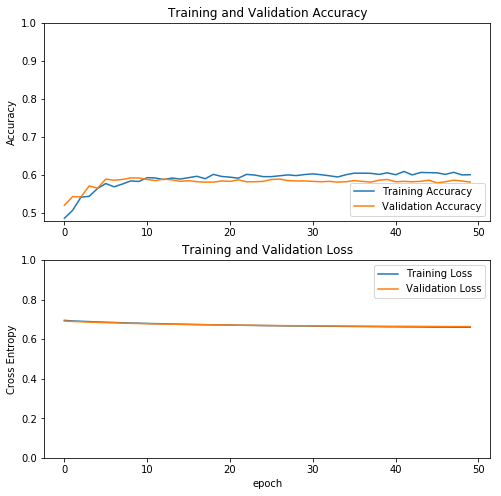

In [25]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()